In [19]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize




In [6]:
!pip install peewee


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.40 requires frozendict>=2.3.4, which is not installed.
yfinance 0.2.40 requires html5lib>=1.1, which is not installed.
yfinance 0.2.40 requires multitasking>=0.0.7, which is not installed.



     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     - -------------------------------------- 0.1/3.0 MB 4.5 MB/s eta 0:00:01
     -- ------------------------------------- 0.2/3.0 MB 3.1 MB/s eta 0:00:01
     ---- ----------------------------------- 0.3/3.0 MB 3.4 MB/s eta 0:00:01
     ------- -------------------------------- 0.6/3.0 MB 4.1 MB/s eta 0:00:01
     -------------- ------------------------- 1.0/3.0 MB 4.7 MB/s eta 0:00:01
     ----------------- ---------------------- 1.3/3.0 MB 5.1 MB/s eta 0:00:01
     --------------------- ------------------ 1.6/3.0 MB 5.0 MB/s eta 0:00:01
     ---------------------- ----------------- 1.6/3.0 MB 5.2 MB/s eta 0:00:01
     ------------------------------ --------- 2.2/3.0 MB 5.5 MB/s eta 0:00:01
     ----------------------------------- ---- 2.6/3.0 MB 5.8 MB/s eta 0:00:01
     ---------------------------------------  2.9/3.0 MB 5.9 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 5.5 MB/s eta 

In [8]:
!pip install frozendict


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.40 requires html5lib>=1.1, which is not installed.
yfinance 0.2.40 requires multitasking>=0.0.7, which is not installed.


In [10]:
!pip install multitasking


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.40 requires html5lib>=1.1, which is not installed.


In [13]:
#Define Tickers and Time range
#First, we define a list of tickers for the assets we want to include in the portfolio. In this example, we use five ETFs representing various asset classes: SPY, BND, GLD, QQQ, and VTI.
tickers = ['SPY','BND','GLD','QQQ','VTI']


In [14]:
#We then set the start and end dates for our analysis. 
#set the end date to today
end_date = datetime.today()


In [50]:
#We use a five-year historical time range for our calculations
#set the start date to 5 years ago
start_date = end_date - timedelta(days = 5*365)

In [16]:
print(start_date)

2019-07-07 00:33:04.798277


In [17]:
#Download Adjusted close Prices
#Create an empty dataframe to store the adjusted close prices of each asset.
adj_close_df = pd.DataFrame()

In [20]:
#We use the yfinance library to download the data from Yahoo Finance.
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [21]:
#Display the dataframe
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2019-07-08  274.340302  72.524582  131.289993  183.771912  140.106583
2019-07-09  274.682190  72.428207  131.750000  184.692184  140.355911
2019-07-10  275.994690  72.489563  133.830002  186.532730  140.928421
2019-07-11  276.641632  72.252991  132.699997  186.397079  141.122269
2019-07-12  277.880157  72.314316  133.529999  187.472351  141.842575
...                ...        ...         ...         ...         ...
2024-06-27  546.369995  72.167953  214.990005  481.609985  268.428009
2024-06-28  544.219971  71.829002  215.009995  479.109985  267.510010
2024-07-01  545.340027  71.449997  215.570007  481.920013  268.049988
2024-07-02  549.010010  71.660004  215.559998  486.980011  269.600006
2024-07-03  551.460022  72.070000  217.990005  491.040009  270.709991

[1257 rows x 5 columns]


In [22]:
#calculate the lognormal returns for each asset 
log_returns=np.log(adj_close_df.shift(1))

In [24]:
#Drop any missing values
log_returns=log_returns.dropna()

In [26]:
#compute the covariance matrix using the annualized log returns.
cov_matrix = log_returns.cov() * 252
print(cov_matrix)


           SPY       BND       GLD        QQQ        VTI
SPY   9.398985 -0.910046  3.817929  11.844065   9.155423
BND  -0.910046  0.805566 -0.239967  -0.603653  -0.727507
GLD   3.817929 -0.239967  2.690448   5.358069   3.643278
QQQ  11.844065 -0.603653  5.358069  15.930767  11.617677
VTI   9.155423 -0.727507  3.643278  11.617677   8.982538


In [27]:
#Define Portfolio Performance Metrics
#calculate the portfolio standard deviation,
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [28]:
#calculate expected return
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

In [30]:
#calculate sharpe ratio
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [40]:
#Portfolio Optimization
#We set the risk-free rate 
risk_free_rate = .02
#define a function to minimize the negative Sharpe ratio
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)


In [34]:
#set constraints and bounds for the optimization process.

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]

In [35]:
#set the initial weights 
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [41]:
#optimize weights to maximize sharpe ratio
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [44]:
# Print the optimized weights
optimal_weights = optimized_results.x

print("Optimal Weights:",optimal_weights)

Optimal Weights: [0.19999999 0.4        0.4        0.         0.        ]


In [46]:
#Display analytics of optimal portfolio
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

SPY: 0.2000
BND: 0.4000
GLD: 0.4000
QQQ: 0.0000
VTI: 0.0000
Expected Annual Return: 1250.7417
Expected Volatility: 1.1506
Sharpe Ratio: 1087.0526


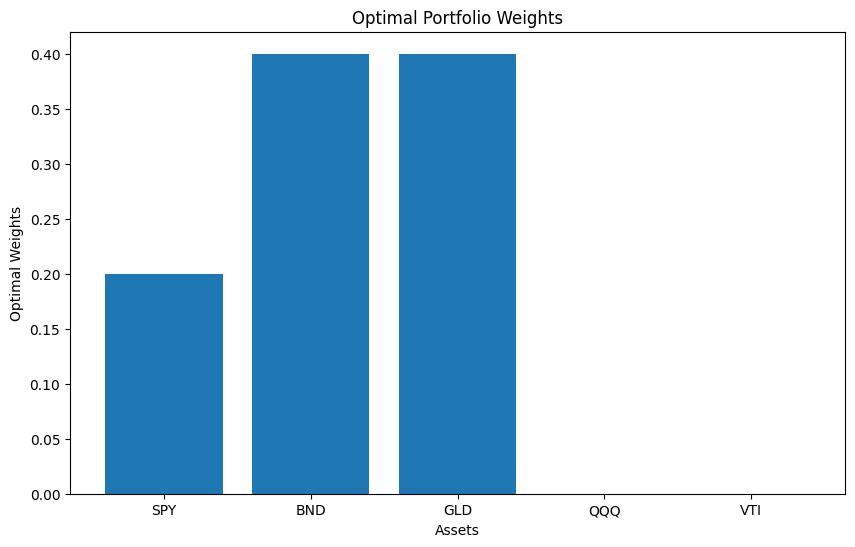

In [49]:
#Display the Final Portfolio in a Plot
#create a bar chart to visualize the optimal weights of the assets in the portfolio.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()